# Setup Environment
Set up the environment by importing necessary libraries and setting up API keys.

In [17]:
# Install required packages
!pip install --quiet langgraph langsmith langchain_openai playwright nest_asyncio

# Import necessary libraries
import os
from getpass import getpass
import nest_asyncio

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Apply nest_asyncio for running async code in Jupyter
nest_asyncio.apply()

# Install Playwright browser
!playwright install


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Define A Helper File

Make sure to create a JS code file called mark_page.js in the same folder as the notebook

# Define Agent State
Define the `AgentState` class to represent the state of the agent, including the webpage, bounding boxes, and predictions.

In [18]:
from typing import List, Optional
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from playwright.async_api import Page

class BBox(TypedDict):
    """
    Represents a bounding box on the webpage with its coordinates and metadata.
    """
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str
    id: Optional[str]

class Prediction(TypedDict):
    """
    Represents the agent's predicted action and its arguments.
    """
    action: str
    args: Optional[List[str]]

class AgentState(TypedDict):
    """
    Represents the state of the agent during execution.
    """
    page: Page  # The Playwright web page object for interacting with the browser
    input: str  # User's input or request
    img: str  # Base64-encoded screenshot of the webpage
    bboxes: List[BBox]  # List of bounding boxes annotated on the webpage
    prediction: Prediction  # The agent's predicted action and arguments
    scratchpad: List[BaseMessage]  # Intermediate steps or system messages
    observation: str  # The most recent response from a tool or action
    ids: List[str]  # List of unique identifiers for the bounding boxes

# Define Tools
Implement the tools for the agent, such as 

1. `click`, 

2. `type_text`, 

3. `scroll`, 

4. `wait`,

5. `go_back`, 

5. `to_google`.

In [19]:
import asyncio
import platform

async def click(state: AgentState):
    """
    Simulates a mouse click on a bounding box identified by its label.
    """
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = int(click_args[0])
    print("Bbox ID clicked: ", bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
        print("Bbox: ", bbox)
        state["ids"].append(bbox_id)
    except IndexError:
        return f"Error: no bounding box for label {bbox_id}"
    x, y = bbox["x"], bbox["y"]

    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"

async def type_text(state: AgentState):
    """
    Simulates typing text into an input field identified by a bounding box label.
    """
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return f"Failed to type in element from bounding box labeled as number {type_args}"
    bbox_id = int(type_args[0])
    text_content = type_args[1]
    try:
        bbox = state["bboxes"][bbox_id]
    except IndexError:
        return f"Error: no bounding box for label {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # Check if MacOS or Windows/Linux
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed '{text_content}' and submitted"

async def scroll(state: AgentState):
    """
    Simulates scrolling within the webpage or a specific element.
    """
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."
    target, direction = scroll_args
    
    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"

async def wait(state: AgentState):
    """
    Simulates a wait action for a fixed duration.
    """
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time} seconds"

async def go_back(state: AgentState):
    """
    Simulates navigating back to the previous page in the browser.
    """
    page = state["page"]
    await page.go_back()
    return f"Navigated back to {page.url}"

async def to_google(state: AgentState):
    """
    Simulates navigating to the Google homepage.
    """
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com"

# Define Browser Annotations
Define the `mark_page` function to annotate the browser page with bounding boxes for the agent to interact with.

In [20]:
import base64
from langchain_core.runnables import chain as chain_decorator

# Load the JavaScript code for annotating the page
with open("original_mark_page.js") as f:
    # Some javascript we will run on each step
    # to take a screenshot of the page, select the
    # elements to annotate, and add bounding boxes
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page: Page):
    """
    Annotates the current browser page with bounding boxes for interactive elements.
    """
    # Execute the JavaScript code to annotate the page
    await page.evaluate(mark_page_script)
    for _ in range(10):  # Retry up to 10 times in case of loading delays
        try:
            bboxes = await page.evaluate("markPage()")  # Get bounding boxes
            break
        except Exception:
            await asyncio.sleep(3)  # Wait before retrying
    screenshot = await page.screenshot()  # Take a screenshot of the page
    await page.evaluate("unmarkPage()")  # Remove annotations after capturing
    bboxes = await page.evaluate("markPage()")  # Get bounding boxes
    return {
        "img": base64.b64encode(screenshot).decode(),  # Encode screenshot as base64
        "bboxes": bboxes,  # Return bounding boxes
    }

# Define Agent
Compose the agent using the annotation function, prompt, LLM, and output parser.

In [21]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    print("Annotated bounding boxes:", marked_page["bboxes"])  # Log the bounding boxes
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Load the prompt template for the agent
prompt = hub.pull("wfh/web-voyager")

# Initialize the LLM with gpt-4o
llm = ChatOpenAI(model="gpt-4o")

# Compose the agent using annotation, prompt, LLM, and output parser
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

/home/teodorrk/projects/cogitoxinfor-agents/.myvenv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.

In [22]:
from langchain_core.messages import SystemMessage
import re

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [23]:
from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)


memory = MemorySaver()
#graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()

#print(graph.get_graph().draw_mermaid())

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

# Google Login function

Create a login function for the Playwright into google

In [ ]:
from playwright.async_api import async_playwright

async def login_to_google(page, email, password):
    """
    Automates Google login using Playwright.
    """
    await page.goto("https://accounts.google.com/")
    await page.fill("input[type='email']", email)
    await page.click("button:has-text('Next')")
    await page.wait_for_selector("input[type='password']")
    await page.fill("input[type='password']", password)
    await page.click("button:has-text('Next')")
    await page.wait_for_load_state("networkidle")
    print("Logged in to Google.")

# Example usage
email = os.getenv("GOOGLE_EMAIL")
password = os.getenv("GOOGLE_PASSWORD")

# Creating the agent

In [ ]:
import uuid

config = {
        "recursion_limit": 150,
        "thread_id": str(uuid.uuid4()),
    }
            

async def call_agent(question: str, page):
    """
    Runs the Web Voyager agent on a given question and displays intermediate steps.
    """
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
            "ids": [],
        },
        config=config,
    )
    
    final_answer = None
    steps = []
    states = {"bboxes": [], "prediction": []}
    pred = []
    async for event in event_stream:
        print("event: ", event)
        if "agent" not in event:
            continue
        #bboxes = event["agent"].get("bboxes") or []
        #states["bboxes"].extend(bboxes)  # Add all bboxes to the list
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        states["prediction"].extend(action_input)
        display.clear_output(wait=True)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if action == "ANSWER":
            print(f"\nFinal answer: {action_input[0]}")
            final_answer = action_input[0]
            break
    return final_answer, states

# Run the Agent
Run the agent on various tasks, such as navigating to a webpage, searching for information, and interacting with web elements.

In [ ]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(
    executable_path="/usr/bin/chromium-browser",
    headless=False,
    args=[
        '--no-sandbox',
        '--disable-blink-features=AutomationControlled',
        ],
)
page = await browser.new_page()
#await login_to_google(page, email, password)

_ = await page.goto("https://www.google.com")


1. Click: ['2']
2. Type: ['6', '"WebVoyager paper arXiv explanation"']
3. Click: ['25']
4. Click: ['9']
5. ANSWER;: ['The WebVoyager paper discusses the development of an innovative large multimodal model (LMM) web agent that operates in real-world scenarios. It bridges gaps in web agents by supporting multimodal inputs and achieving a 59.1% task success rate on benchmarks, outperforming existing models and offering reliable and accurate web agent assessments.']


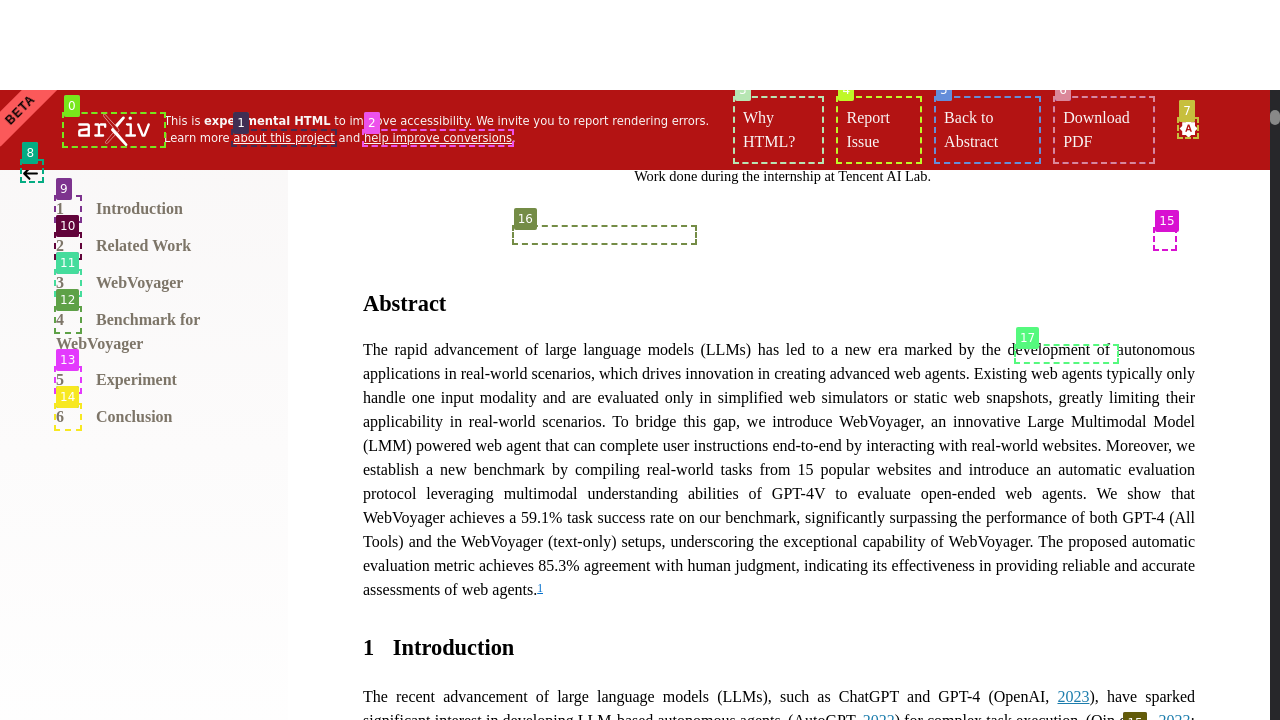

Final response: {'bboxes': [], 'prediction': ['2', '6', '"WebVoyager paper arXiv explanation"', '25', '9', 'The WebVoyager paper discusses the development of an innovative large multimodal model (LMM) web agent that operates in real-world scenarios. It bridges gaps in web agents by supporting multimodal inputs and achieving a 59.1% task success rate on benchmarks, outperforming existing models and offering reliable and accurate web agent assessments.']}


In [ ]:
res, states = await call_agent(
        """Could you explain the WebVoyager paper (on arxiv)?
        """, page)

print(f"Final response: {states}")

In [ ]:
states

{'bboxes': [],
 'prediction': ['2',
  '6',
  '"WebVoyager paper arXiv explanation"',
  '25',
  '9',
  'The WebVoyager paper discusses the development of an innovative large multimodal model (LMM) web agent that operates in real-world scenarios. It bridges gaps in web agents by supporting multimodal inputs and achieving a 59.1% task success rate on benchmarks, outperforming existing models and offering reliable and accurate web agent assessments.']}

In [ ]:
import os

def list_folder_contents(folder_path):
    """
    Lists the contents of a given folder.
    :param folder_path: Path to the folder to list contents from.
    :return: List of files and directories in the folder.
    """
    try:
        contents = os.listdir(folder_path)
        print(f"Contents of '{folder_path}':")
        for item in contents:
            print(f"- {item}")
    except FileNotFoundError:
        print(f"Error: The folder '{folder_path}' does not exist.")
    except PermissionError:
        print(f"Error: Permission denied to access '{folder_path}'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
folder_path = "/mnt/c/Program Files/Google/Chrome/Application/"
list_folder_contents(folder_path)

Contents of '/mnt/c/Program Files/Google/Chrome/Application/':
- 134.0.6998.178
- 134.0.6998.89
- chrome.exe
- chrome.VisualElementsManifest.xml
- chrome_proxy.exe
- initial_preferences
- new_chrome.exe
- new_chrome_proxy.exe
- SetupMetrics
